# Project title: Links between scholars' collaboration network properties, research output, and Twitter usage: a pilot study 

# Author: Dmitri Rozgonjuk

The present Jupyter Notebook includes the complete data retrieval, pre-processing, and main analysis presentation for the Network Science (LTAT.02.011) course project in Spring 2022. 

In order to be able to run this code from beginning to the end, it is necessary to have API keys for Scopus and Twitter, since I am not including mine with this notebook. I have provided some support for these steps in the relevant sections.

This said, some parts of the code may take a longer time to run. It is also possible to skip the data retrieval and pre-processing steps and go directly to main analyses, granted that the data is appended (which it should be).

# 0. Setup

Setup includes importing the necessary libraries and other settings.

In [1]:
# Multipurpose libraries
import pandas as pd # Data tables and data manipulation
import numpy as np # Arrays and mathematical operations on them
import re # Regex operations
from tqdm import tqdm # Displaying the N of operations and time for for-loops
import matplotlib.pyplot as plt # Visualization
import seaborn as sns # Visualization
from datetime import datetime # Extracting the date
import time # Time-related operations (e.g, sleep)
import warnings # For suppressing warnings output
warnings.filterwarnings('ignore')

# For Google Scholar web scraping module
from requests import get # URL-data requests
from bs4 import BeautifulSoup # html-data parsing

# Scopus module
from pybliometrics.scopus import AuthorSearch # Author search on Scopus
from scop_module import scopus_data, nodes_data, edges_data # Custom module for data retrieval and network data preparation from Scopus

# Twitter module
import tweepy # Twitter API

# Network analysus module
import networkx as nx # Network analysis library
import community.community_louvain as community_louvain # Louvain community detection

# Main analysis module
from scipy.stats import spearmanr # Spearman rho
from pingouin import partial_corr # Partial correlation analysis
from statsmodels.stats.multitest import fdrcorrection # FDR-correction for p-values

# Time of the start of the entire pipeline
start_pipeline = datetime.now()
print("Pipeline started:", start_pipeline)

Pipeline started: 2022-05-12 16:26:30.062991


# 1. Get the list of researchers on Google Scholar

While the present module has shown stability over the couple of months that I have been working on this project, it still has a somewhat manual approach to it. The aim at this stage was to produce a workflow to meet the project goals for the Network Science course; however, a longer-term aim is to make this module more automatic.

**How does this module work?**

- In essence, one needs to navigate to a Google Scholar page that lists researchers based on their affiliation. This is the starting URL. First, the link patterns are retrieved. Then, the first page is scraped, followed by a for-loop that runs in sequences of 10 (the number of researchers on one page) until the user-defined number. The URLs are appended into a list. So if the aim is to collect 1010 researchers' profiles, starting N = 10 (since 10 are collected as a first step before the loop) and ending N = 1010. My example uses the reseachers with Unviersity of Tartu affiliation.

- Once the list of links is collected, the URLs are iterated over and the names and citation counts of researchers are collected into lists. Additionally, basic text data cleaning is performed (removing non-name related interpunctuation, academic titles, etc).

- The results are then saved into a .csv-file where the file name also reflects the sample size and date of the data extraction.

In [2]:
# 1.1. # First page: Get the patterns for further data extraction

url_start = 'https://scholar.google.ca/citations?view_op=view_org&org=9530521569547719594&hl=en&oi=io'
response = get(url_start)
html_soup = BeautifulSoup(response.text, 'html.parser')
button_info = str(html_soup.find_all("button", class_ = "gs_btnPR gs_in_ib gs_btn_half gs_btn_lsb gs_btn_srt gsc_pgn_pnx"))
after_auth_string = (re.search('after_author\\\\x3d(.*)\\\\x26astart', button_info)).group(1)

In [3]:
# 1.2. Extract the list of links

urls = [] # placeholder for a list of URLs
# Extract the data of first page
url_start = 'https://scholar.google.ca/citations?view_op=view_org&org=9530521569547719594&hl=en&oi=io'
urls.append(url_start)
response= get(url_start)
html_soup = BeautifulSoup(response.text, 'html.parser')
button_info = str(html_soup.find_all("button", class_ = "gs_btnPR gs_in_ib gs_btn_half gs_btn_lsb gs_btn_srt gsc_pgn_pnx"))
after_auth = (re.search('after_author\\\\x3d(.*)\\\\x26astart', button_info)).group(1)

# Extract data of other pages (specify the max number of researchers)
n = 1010
for i in tqdm(range(10, n, 10)):
    url_next = "https://scholar.google.ca/citations?view_op=view_org&hl=en&org=9530521569547719594&after_author=" + str(after_auth) + "&astart=" +str(i)
    urls.append(url_next)
    response = get(url_next)
    html_soup = BeautifulSoup(response.text, 'html.parser')
    button_info = str(html_soup.find_all("button", class_ = "gs_btnPR gs_in_ib gs_btn_half gs_btn_lsb gs_btn_srt gsc_pgn_pnx"))
    after_auth = (re.search('after_author\\\\x3d(.*)\\\\x26astart', button_info)).group(1)
    # print(i, sep = " ")

100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


In [4]:
# 1.3. Use list of URLs to extract the researchers and their citations
URLs = urls
names = []
cites = []
for URL in tqdm(URLs):
    response = get(URL)
    html_soup = BeautifulSoup(response.text, 'html.parser')
    # find the class with name
    d = str(str(html_soup.find_all(class_ = "gs_ai_name", recursive = True)).split("AAAJ\">")).split("</a><")
    # find citations
    d2 = str(str(html_soup.find_all(class_ = "gs_ai_cby", recursive = True)).split("Cited by ")).split("</div")
    
    for i in range(len(d)):
        if ", \'" in d[i]:
            n = d[i].split(", \'")[1] # get the name
            c = d2[i].split(", \'")[1] # get the citations
            
            # append the results
            names.append(n)
            cites.append(c)
            # print(n, c)
            
df_gs = pd.DataFrame(list(zip(names, cites)), columns = ["name_gs", "cites"])

# A bit of data cleaning in name
df_gs["name_gs"] = df_gs["name_gs"].str.replace(" MD", "")
df_gs["name_gs"] = df_gs["name_gs"].str.replace(" PhD", "")
df_gs["name_gs"] = df_gs["name_gs"].str.replace(",", "")
df_gs["name_gs"] = df_gs["name_gs"].str.replace(")", "")
df_gs["name_gs"] = df_gs["name_gs"].str.replace("(", "")
df_gs["name_gs"] = df_gs["name_gs"].str.strip()

100%|██████████| 101/101 [01:42<00:00,  1.02s/it]


In [5]:
# Save the results to csv
## add date to the filename as well as the number of researchers
file_name = "ut" + str(len(df_gs)) + "_" + str(datetime.now().date()) + ".csv"
df_gs.to_csv(file_name, index = False)
df_gs.head() # see the head of df

,name_gs,cites
0,Andres Metspalu,110139
1,Tõnu Esko,88114
2,Risto Näätänen,78863
3,Reedik Mägi,52523
4,Mikk Jürisson,46689


# 2. Search for researchers on Scopus

The present module works so that the names of researchers are used to perform queries in Scopus via the Scopus API (using the pybliometrics library). However, in order to execute such queries, one needs to have the API credentials (keys) in Elsevier Developer Portal (EDP). These keys are typically linked to an institution - in my case, my university. In order to get the keys, therefore, one needs to register on the EDP likely via their institution. Once the user is registered and the key is retrieved, one needs to configure one of the files in the pybliometrics library; see https://pybliometrics.readthedocs.io/en/stable/configuration.html for details. Once this is done, it may be necessary to access Scopus (also via the API) through the institution's network (in my case, the university's VPN is useful). Naturally, therefore, this module will not run without these credentials.

**How does this module work**

- The input needed is the data frame extracted in the previous step. Regardless, the search queries could also be executed with custom lists not necessarily dependent on the first module.

- I wrote a custom function for better clarity that takes the lists of first and last names as well as affiliation city as arguments; the function returns a data frame with researchers and their preliminary data. The affiliation city is added to further increase the accuracy of the query result. Of course, it could happen that there is a different affiliation city in Scopus. For instance, in case it is so that while I am affiliated with University of Tartu on Google Scholar, the affiliation in the Scopus database shows Ulm University (hence, the city is Ulm). I don't think this is a big issue, though, since the number of researchers not found is relatively small. I won't get into much detail with the function, as it includes all necessary description within it.

- Of note, it is also possible to sample a number of researchers (e.g., N = 100) from the dataframe of all researchers (e.g., N = 1000) for testing or other purposes.


In [6]:
# The function for Scopus data retrieval
def scopus_author_search(last_name_list, first_name_list, affil_city):
    
    '''
    Args: list of last names, list of first names, and list of affiliation cities of researchers.
    Returns: a Pandas data frame that includes: researchers' Google Scholar name, Scopus name
            Scopus ID, the number of search query results, country of affiliation, the number of documents, and areas of research.
    How it works: the user provides lists of seach query elements. Scopus API (from pybliometrics.scopus) does the heavy-lifting.
            Based on search query, there are three outcomes: 
            (a) one query result: the researcher's data is extracted and added to the data table;
            (b) more than 10 query results: the researcher's name is kept, and the number of queries added. No additional data are retrieved;
            (c) the number of queries is between 10 > N queries > 1: the first one on the list is extracted;
            (d) the query results in 0 findings: the name and 0 in number of queries is added to the data table.
            
            The function also prints the counts for (a)-(d).    
    '''
    
    valid_name = 0
    large_n_searchresults = 0
    multiple_accounts_manageable = 0
    missing = 0
    
    # Data Frame with preliminary author information
    scopus_author = pd.DataFrame(columns=['name_gs', # Scholar name
                                      'scopus_name', # Scopus name
                                      'scopus_id', # Scopus ID
                                      "n_query_results", # How many results found?
                                      'country_aff', # Country of affiliation
                                      'n_docs', # Number of documents
                                      'areas_research' # Areas of research
                                     ])

    scopus_df = []
    for i in tqdm(range(len(last_name_list))):
        
        # For Scopus query, use (1) Author last name, (2) Author First name, (3) Author affiliation city
        s = AuthorSearch(f"AUTHLAST({last_name_list[i]}) and AUTHFIRST({first_name_list[i]}) and AFFILCITY({affil_city})", integrity_fields=["eid"], integrity_action="warn")
        
       # print("{" + last_name_list[i], first_name_list[i] + "}")
        
         # In case there are ANY results
        if s.authors is not None:
            
            # In case only 1 query result:
            if len(s.authors) == 1:
                scopus_author = scopus_author.append({
                    "name_gs": df_gs_sample["name_gs"][i],
                    "scopus_name":s.authors[0][2] + "; " + s.authors[0][4],
                                      "scopus_id" : s.authors[0][0].split("-")[2],
                                      "n_query_results" : 1,
                                      "country_aff" : s.authors[0][9], # Affilition country
                                      "n_docs" : s.authors[0][6], # number of documents
                                      "areas_research": s.authors[0][10] # areas                      
                                     }, ignore_index=True)
                valid_name += 1
            
            else:
                
                # If more than 10 results
                if len(s.authors) >= 10:
                  #  print("- The query with this author name yields", str(len(s.authors)), "results. That is too much.\n")
                    
                    scopus_author = scopus_author.append({
                        "name_gs": df_gs_sample["name_gs"][i],
                        "scopus_name":s.authors[0][2] + "; " + s.authors[0][4],
                                      "n_query_results" : len(s.authors),
                                     }, ignore_index=True)
                    
                    large_n_searchresults += 1
                else:
                    # If less than 10 results, pick the first one
                   # print(len(s.authors),  "authors were found with this name\n")
                    scopus_author = scopus_author.append({
                        "name_gs": df_gs_sample["name_gs"][i],
                        "scopus_name":s.authors[0][2] + "; " + s.authors[0][4],
                                          "scopus_id" : s.authors[0][0].split("-")[2],
                                          "n_query_results" : len(s.authors),
                                          "country_aff" : s.authors[0][9], # Affilition country
                                          "n_docs" : s.authors[0][6], # number of documents
                                          "areas_research": s.authors[0][10] # areas                      
                                         }, ignore_index=True)

                    multiple_accounts_manageable += 1
        else:
            #print("- No information in Scopus\n")
            scopus_author = scopus_author.append({
                    "name_gs": df_gs_sample["name_gs"][i],
                                      "n_query_results" : 0,            
                                     }, ignore_index=True)
            
            
            missing += 1

    print("Matched accounts: ", str(valid_name), "\n",
          "Multiple accounts (manageable): ", str(multiple_accounts_manageable), "\n",
          "Multiple accounts (too many): ", str(large_n_searchresults), "\n",
          "No account found: ", str(missing)
         )
    
    return scopus_author # Return the data frame

In [7]:
# 2.1. Import the data (from previously-saved csv or use the data frame created in the previous module)
# df_gs = pd.read_csv([FILENAME])
# print(df_gs.head())

# Sampling possiblity: sample 100 names from all names
# df_gs_sample = df_gs.sample(100).reset_index(drop = True)
# In case no sampling is done, use the data from previous step (or from importedd csv)
df_gs_sample = df_gs
print(df_gs_sample.head())

           name_gs   cites
0  Andres Metspalu  110139
1        Tõnu Esko   88114
2   Risto Näätänen   78863
3      Reedik Mägi   52523
4    Mikk Jürisson   46689


In [8]:
# 2.2. Extract the list of first and last names
firsts = []
lasts = []
for name in df_gs_sample["name_gs"]:
    firsts.append(name.split(" ")[0])
    lasts.append(name.split(" ")[-1])
firsts = pd.Series(firsts)
lasts = pd.Series(lasts)

# added another layer of df cleaning - it didn't work in the first stage for some reason
## Maybe needs to be improved
for i in range(len(lasts)):
    firsts[i] = firsts[i].strip(")")
    firsts[i] = firsts[i].strip("(")
    lasts[i] = lasts[i].strip(")")
    lasts[i] = lasts[i].strip("(")

In [9]:
# 2.3. Use the function
# NB! Make sure to connect to an institutional VPN (or be in the institution's network)
# Affiliation city is set to Tartu -> for University of Tartu
d = pd.DataFrame(scopus_author_search(lasts, firsts, "Tartu")) # use the Scopus author search function
academic_df = df_gs_sample.merge(d) # merge the extracted data with the Google Scholar results
academic_df.head(5) # show the head of df

100%|██████████| 1006/1006 [00:22<00:00, 45.52it/s]

Matched accounts:  912 
 Multiple accounts (manageable):  34 
 Multiple accounts (too many):  0 
 No account found:  60


,name_gs,cites,scopus_name,scopus_id,n_query_results,country_aff,n_docs,areas_research
0,Andres Metspalu,110139,Metspalu; Andres,7004697483,2,Estonia,426,BIOC (380); MEDI (284); NEUR (46)
1,Tõnu Esko,88114,Esko; Tõnu,26648246800,2,Estonia,285,BIOC (248); MEDI (154); AGRI (35)
2,Risto Näätänen,78863,Näätanen; Risto,7102235968,2,Denmark,393,NEUR (375); MEDI (188); PSYC (173)
3,Reedik Mägi,52523,Mägi; Reedik,56813518300,1,Estonia,242,BIOC (221); MEDI (147); AGRI (35)
4,Mikk Jürisson,46689,JÜRISSON; Mikk,55547524800,1,Estonia,66,MEDI (66); BIOC (4); MULT (2)


In [10]:
# Save as a csv file
file_name2 = "ut_scop" + str(len(academic_df)) + "_" + str(datetime.now().date()) + ".csv"
academic_df.to_csv(file_name2, index = False)

# 3. Search for the researchers on Twitter

This module within the whole pipeline is probably the trickiest. The intended approach is simple: performing a name search on Twitter.

**How this module works**

- First, the dataset from previous step (either used directly or imported from a csv) is used. To be exact, only the names where Scopus queries were frutiful are used.
- A for-loop is used to iterate over all eligible data frame rows. The name from Google Scholar is used to perform a nae search on Twitter via the Twitter API (tweepy library). Similarly to Scopus, one needs to register a Twitter Developer Account (TDA) to receive the Twitter API keys. It could hapeen that registration takes some time (a couple of days even). As with Scopus module, I am not providing my own credentials, hence this module will not run: I advise to create one's own TDA.
- However, when the setup is all good (with credentials and what-not), the for-loop iterates over each name, performs a search, and if there is ONE search result, this will be matched to a queried researcher's data. The reason here is that, unlike in Scopus, it may be way more likelier that the multiple results are for different people; while in Scopus, the query results are listed by the number of documents - making it highly likely that the query result matches the actually queried person - there is no such 'guarantee' on Twitter. In other words, on Twitter, multiple result could be copletely different people. Hence, with the risk of excluding a lot of accounts, but with the upside of potentially increasing the accuracy of findings, only if one query is returned, this is matched to the queried person in the data set.
- The data included are: Twitter name, Twitter account name, Twitter ID, number of tweets, number of users followed, number of followers, number of likes, date of Twitter account creation, and years on Twitter (date of account creation subtracted from local machine's system time). Of course, there is a possiblity to extract more information, such as bio, location, etc, but it is out of the scope of the current project.
- NB! Since Twitter limits the number of queries within a specific time frame (it shoul be 15 minutes), the for-loop is adjusted accordingly so that the system 'sleeps' for 15 minutes after 599 queries (and then 1199). Sleep interval can be adjusted. Of course, the time, too - but when I experimented with shorter times than 15 minutes, I received errors. So all that time went to waste. :) Keep it at 15 minutes.
- Once the data are extracted, the data table is merged with data from previous steps, and it is saved into a csv file.

In [11]:
# academic_df = pd.read_csv([FILENAME])
df_all_academic = academic_df[academic_df["n_query_results"] > 0] # Using only the names that were matched with scopus
df_all_academic.shape # just to check the dimensions of the df

(946, 8)

In [12]:
# Twitter API Authentication
## You need your own key here
auth = tweepy.OAuth2BearerHandler("AAAAAAAAAAAAAAAAAAAAAEXsaAEAAAAABlt%2FEwT1XZLwNLnOxI%2FgSg1KXLU%3DiQMpYq687E4OkaexdNLVxbteUEZrmi7XMIpn5TXF8GfDHfVW3n")
api = tweepy.API(auth)

In [13]:
# Creating the df where the query results will be stored
df = []

start_time = datetime.now().strftime("%H:%M:%S") # Track the time it takes to run all queries
print("Time started:", start_time)
count = 0 # count for the number of queries performed, "sleep" when a certain number of queries is made
for n in tqdm(df_all_academic["name_gs"]):
    count += 1
    if count in [600, 1200]: # go to sleep after 600 and 1200 queries
        print("Sleeping for 15 min...", "started sleeping at:", datetime.now().strftime("%H:%M:%S"))
        time.sleep(60*15) # sleep for 15 minutes
        print("What a nice nap it was... Let's get back to work. The time is:", datetime.now().strftime("%H:%M:%S"))
    else:
        search = api.search_users(n)
        if len(search) == 1:
            df.append(
                { "name_gs" : n,
                        "name_twitter": search[0].name,
                         "twitter_id": search[0].id,
                        "twitter_account" : search[0].screen_name,
                      #  "twitter_bio" : search[0].description,
                      #  "twitter_location" : search[0].location,
                         "ntTweets" : search[0].statuses_count, # number of tweets
                        "ntFwd" : search[0].friends_count, # number of users followed
                        "ntFws" : search[0].followers_count, # number of followers
                        "ntLikes" : search[0].favourites_count, # number of likes
                        "date_created" : search[0].created_at,
                      #  "year_created" : int(search[0].created_at.year)
                         "yTwitter" : datetime.now().year - int(search[0].created_at.year) # years on Twitter
                }
            )
df = pd.DataFrame(df).sort_values("date_created", ascending = False)
time_end = datetime.now().strftime("%H:%M:%S")
print("Time ended:", time_end)

  0%|          | 0/946 [00:00<?, ?it/s]

Time started: 16:30:17


 63%|██████▎   | 599/946 [04:46<02:35,  2.23it/s]

Sleeping for 15 min... started sleeping at: 16:35:04


 63%|██████▎   | 600/946 [19:46<25:58:47, 270.31s/it]

What a nice nap it was... Let's get back to work. The time is: 16:50:04


100%|██████████| 946/946 [22:36<00:00,  1.43s/it]    

Time ended: 16:52:54


In [14]:
# Merge and save the data
df_all = df_all_academic.merge(df)
file_name3 = "ut_all_N" + str(len(df_all)) + "_" + str(datetime.now().date()) + ".csv"
df_all.to_csv(file_name3, index = False)
df_all.shape # check the dimensions of data

(261, 17)

# 4. Extracting the networks data from Scopus

This module includes the extraction of researchers' sceintific output as well as ocllaboration network data. One may wonder: why not do it in the first Scopus query? The reason is simple: since the aim of the present project was to link scientific output to Twitter data, there would be unnecessary computational overhead for extracting all data to just keeping a part of it. Hence, here only the resaerchers whose Twitter profile was found were proceeded with to the next stage.

NB! This module uses a custom module for data retrieval and nodes and edges data creation, because the module ahs to be on a local machine (where the pybliometrics configurations are done).

**How this module works**

- The data from previous module (or from a saved csv) need to be used.
- Additional variables regarding scientific output and collaboration metrics are created to the dataframe with an initial value of 0. This is updated during the query.
- The for-loop is initiated where the researcher's Scopus ID is used for a Scopus query. The Scopus query is a custom function (please see the details within the function) that uses the Scopus ID as input and retrieves a data table with the researcher's research output, i.e., a data table with each publication's year, title, authors and their Scopus IDs, and the number of citations. As a result, this functionality allows to update the research output metrics of a researcher to the main table (i.e., table that includes the Twitter data, too).
- Next, the information of unique nodes is extracted: names and the number of publications with the ego-node (included). In case there is an error (e.g., the ego-node cannot be found among the authors of a publication - a situation that might happen in publications with large number of co-authors that list expert groups instead of individuals authors), the author's data is not included in subsequent querying. Then, nodes' data is used for extracting all collaborations (edges) for network analysis.
- I also added a relatively arbitrary condition to this module. Namely, I gloss over the researchers with more than 1000 collaborators, since they are likely outliers. The practical reason is that, say if we have several papers with thousands of authors (as is the case, for instance, in CERN-related publications). It takes a lot of time to compute the collaboration networks, yet it may not be highly meaningful, since it will likely be one cluster anyway. Hence, I decided to not spend additional resources on these cases - however, with more computational power (and waiting tilerance :) ), one may remove this condition.
- The next step is computing networks. One may ask: why not save each researcher's Scopus data and THEN perform the network analysis (as opposed to my current process where it is all done in the for-loop iteration). My answer is: since the scope is not wider for the current project, I figured that I would save on potential computational overhead. After all, I need just a copuple of network statistics to be used.
- There are two types of networks I am interested in: the one with the ego-node (research) included in the network and the one where the researcher is excluded. The  idea behind this is to see if when we remove the ego-node, does the number of communities (and components) change in the network. In other words, does the ego-node (researcher) connect groups that might be entities on their own without the researcher?
- As mentioned, the network properties of interest, therefore, are the number of communities as well as the number of connected components in both networks. Based on these properties, two additional variables are computed: the difference in the number of communities, and the difference in the number of connected components.
- Once the data are exctracted, the data table is saved as a csv.

In [15]:
# Import the data and create additional variables to the data table
# df_all = pd.read_csv([FILENAME])

# General pubs and collabs info
df_all["yCareer"] = 0 # Years since first publication
df_all["nCoAuths"] = 0 # number of co-authors (minus self)
df_all["nPubs"]= 0 # number of publications
df_all["nCites"] = 0 # number of total citations
df_all["nCitesPP"]= 0 # average number of citations per publication
df_all["nCollabsTooHigh"] = 0 # if the number of collaborators is too high = 1

# Collaboration network metrics
df_all["nCsWR"] = 0 # number of communities with ego-node network
df_all["nCCmpWR"] = 0 # number of connected components with ego-node network
df_all["nCsWOR"] = 0 # number of communities WITHOUT the ego-node network
df_all["nCCmpWOR"] = 0 # number of connected components WITHOUT the ego-node network
df_all["nCsDif"] = 0 # difference of communities between two networks
df_all["nCCmpDif"] = 0 # difference in connected components between two networks

# df_all["nIsolatesWOR"] = 0 # number of isolates WITHOUT the ego-node network
df_all_sample = df_all #.sample(100).reset_index(drop = True)
df_all_sample.head()

,name_gs,cites,scopus_name,scopus_id,n_query_results,country_aff,n_docs,areas_research,name_twitter,twitter_id,...,nPubs,nCites,nCitesPP,nCollabsTooHigh,nCsWR,nCCmpWR,nCsWOR,nCCmpWOR,nCsDif,nCCmpDif
0,Tõnu Esko,88114,Esko; Tõnu,26648246800,2,Estonia,285,BIOC (248); MEDI (154); AGRI (35),Tõnu Esko,2207626603,...,0,0,0,0,0,0,0,0,0,0
1,Reedik Mägi,52523,Mägi; Reedik,56813518300,1,Estonia,242,BIOC (221); MEDI (147); AGRI (35),Reedik Mägi,1153324974922489863,...,0,0,0,0,0,0,0,0,0,0
2,Leho Tedersoo,32707,Tedersoo; Leho,8599681300,1,Estonia,202,AGRI (223); BIOC (113); ENVI (74),Leho Tedersoo,2898064637,...,0,0,0,0,0,0,0,0,0,0
3,Jüri Allik,27395,Allïk; Jüri,7003428288,1,Estonia,217,PSYC (215); NEUR (65); MEDI (60),Jüri Allik,1498570711987851264,...,0,0,0,0,0,0,0,0,0,0
4,Urmas Kõljalg,26181,Kõljalg; Urmas,6603238587,1,Estonia,95,AGRI (104); BIOC (56); ENVI (32),Urmas Kõljalg,2791326731,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Running the loop for data retrieval 

for i in tqdm(range(len(df_all_sample))): # 
    id_researcher = df_all_sample["scopus_id"][i]

    # Compute network stats values and add to the main table
    ## Prepare the networks data
    scopus_df = scopus_data(id_researcher)
    
    df_all_sample["yCareer"][i] = datetime.today().year - int(scopus_df["year"].min())
    df_all_sample["nCoAuths"][i] = pd.Series(";".join(scopus_df["auids"]).split(";")).nunique() - 1 # number of co-authors (minus self)
    df_all_sample["nPubs"][i] = len(scopus_df)
    df_all_sample["nCites"][i] = scopus_df["n_citations"].sum()
    df_all_sample["nCitesPP"][i] = scopus_df["n_citations"].sum()/len(scopus_df)
    
    try:
        d_nodes = nodes_data(scopus_df) # see if it's possible to get the node data
    except:
        df_all_sample["nCollabsTooHigh"][i] = 1
        continue
    
    if(df_all_sample["nCoAuths"][i] > 2000): # if more than 1000 collaborators, mark the author as outlier
        df_all_sample["nCollabsTooHigh"][i] = 1
        continue
    else: 
        node_df = pd.DataFrame(d_nodes).transpose().sort_values("nPubs", ascending = False) # nodes data table
        edge_df = edges_data(d_nodes) # Edges data table

        if (len(d_nodes.keys()) - 1) == 0: # In case there are no co-authors, take the next one in line
            continue
        else:
            # Weighted undirected networks with and without the researcher (N of collaborations used as weights)
            # G1: graph WITH the researcher
            edges = edge_df.groupby(['author1', 'author2'])['nCollabs'].sum().reset_index()
            G1 = nx.from_pandas_edgelist(edges, source='author1', target='author2',edge_attr=True)
            
            # network stats with the researcher
            df_all_sample["nCsWR"][i] = len(set(community_louvain.best_partition(G1, weight = "nPubsE").values()))
            df_all_sample["nCCmpWR"][i] = nx.number_connected_components(G1)
            
            ## network stats WITHOUT the researcher
            G1.remove_node(str(id_researcher))
            df_all_sample["nCsWOR"][i]= len(set(community_louvain.best_partition(G1, weight = "nPubsE").values()))
            df_all_sample["nCCmpWOR"][i] = nx.number_connected_components(G1)
          #  df_all_sample["nIsolatesWOR"][i] = nx.number_of_isolates(G1) <- not really necessary, since included in connected components statistics
        
            # Compute the differences in network metrics
            df_all_sample["nCsDif"][i] = df_all_sample["nCsWOR"][i] - df_all_sample["nCsWR"][i] # Difference of communities between two networks
            df_all_sample["nCCmpDif"][i] = df_all_sample["nCCmpWOR"][i] - df_all_sample["nCCmpWR"][i] # Difference in connected components between two networks
            

100%|██████████| 261/261 [34:59<00:00,  8.04s/it] 


In [17]:
# Save the data
file_name4 = "full_df" + str(len(df_all_sample)) + "_" + str(datetime.now().date()) + ".csv"
df_all_sample.to_csv(file_name4, index = False)
df_all_sample.head()

,name_gs,cites,scopus_name,scopus_id,n_query_results,country_aff,n_docs,areas_research,name_twitter,twitter_id,...,nPubs,nCites,nCitesPP,nCollabsTooHigh,nCsWR,nCCmpWR,nCsWOR,nCCmpWOR,nCsDif,nCCmpDif
0,Tõnu Esko,88114,Esko; Tõnu,26648246800,2,Estonia,285,BIOC (248); MEDI (154); AGRI (35),Tõnu Esko,2207626603,...,287,53599,186.756098,1,0,0,0,0,0,0
1,Reedik Mägi,52523,Mägi; Reedik,56813518300,1,Estonia,242,BIOC (221); MEDI (147); AGRI (35),Reedik Mägi,1153324974922489863,...,242,35554,146.917355,1,0,0,0,0,0,0
2,Leho Tedersoo,32707,Tedersoo; Leho,8599681300,1,Estonia,202,AGRI (223); BIOC (113); ENVI (74),Leho Tedersoo,2898064637,...,204,23680,116.078431,0,16,1,17,4,1,3
3,Jüri Allik,27395,Allïk; Jüri,7003428288,1,Estonia,217,PSYC (215); NEUR (65); MEDI (60),Jüri Allik,1498570711987851264,...,218,13514,61.990826,0,9,1,19,9,10,8
4,Urmas Kõljalg,26181,Kõljalg; Urmas,6603238587,1,Estonia,95,AGRI (104); BIOC (56); ENVI (32),Urmas Kõljalg,2791326731,...,95,18035,189.842105,0,10,1,9,3,-1,2


# 5. Main analysis

This is the final module of the entire pipeline, as the data from previous steps are used for main analyses. 

**How this module works**
- The complete data set is used from the previous module (or imported from a saved csv). The outliers with more than 1000 collaborators are excluded. Only the data for main analyses is kept (that is, personall identifiers, etc are excluded).

- The results are computed. First, the table with descriptive statistics for all variables. Then, Spearman correlation analysis is conducted. Career years and Twitter years are correlated with other variables, whereas these other metrics (research output, collaboration network metrics, Twitter data) are correlated with each other so that career years and/or Twitter years are partialled out. Then, p-values are adjusted for false discovery rate. Finally, a correlogram (heatmap) with significant correlation is returned. The color denotes correlation direction and color intensity the strength of correlation. 'X' is marked in the cell where the correlation was not statistically significant.

- Both table and figure are displayed; the figure is also saved as a png.

- A question might arise: since the distributions are not normal virtually in all variables, would transformations be necessary? In principle, this could be done, yes. However, the scope of this work is testing associations - hence, I've opten for non-parametric, rank-based correlation analysis (Spearman) that kind of takes care of the non-normality.

In [18]:
# Data import
# df_all_sample = pd.read_csv([FILENAME])

# Exlude the outliers with too many collaborations
df = df_all_sample[df_all_sample['nCollabsTooHigh'] == 0]

# Creating a clean data set: only with variables necessary for analysis
df = df[['scopus_id','yCareer', 'nCoAuths',
    'nPubs', 'nCites', 'nCitesPP',
    'nCsWR', 'nCsWOR',"nCsDif",
    'nCCmpWR', 'nCCmpWOR','nCCmpDif',
    'yTwitter', 'ntTweets',
       'ntFwd', 'ntFws', 'ntLikes'
   ]].set_index('scopus_id')

### Table I. Descriptive statistics

In [19]:
desc_table = round(df.describe().transpose()[["mean", "std", "min", "max"]],2)
desc_table["median"] = round(df.median(),2)
desc_table["mad"] = round(df.mad(),2)
desc_table = desc_table[["mean", "std","median", "mad", "min", "max"]]
desc_table

,mean,std,median,mad,min,max
yCareer,12.95,8.85,11.00,7.09,0.0,53.00
nCoAuths,116.21,214.20,34.00,128.83,0.0,1563.00
nPubs,27.46,37.59,16.00,23.33,1.0,266.00
nCites,984.98,2560.47,166.00,1237.08,0.0,23680.00
nCitesPP,21.47,30.31,10.07,19.79,0.0,189.84
nCsWR,3.64,2.33,3.00,1.83,0.0,16.00
nCsWOR,5.14,3.73,5.00,2.80,0.0,19.00
nCsDif,1.49,2.29,1.00,1.61,-1.0,14.00
nCCmpWR,0.97,0.20,1.00,0.07,0.0,2.00
nCCmpWOR,2.97,2.83,2.00,1.99,0.0,17.00


### Partial correlations heatmap

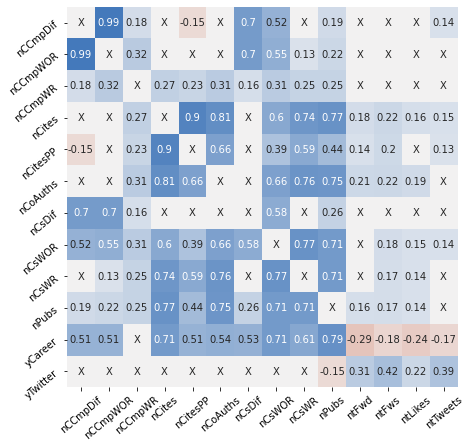

In [20]:
# Create a table where the results are going to be stored
part_cors = pd.DataFrame(columns=['x', 'y', 
                                 'covar1', 'covar2', 
                                 'n', 'rho', 'CI95', 'p'])

# The association between career years and other variables
x = 'yCareer'
vars1 = ['nCoAuths', 'nPubs', 'nCites', 'nCitesPP', 
         'nCsWR', 'nCsWOR',  'nCsDif',     
         'nCCmpWR', 'nCCmpWOR','nCCmpDif',
         'yTwitter', 'ntTweets', 'ntFwd',
         'ntFws', 'ntLikes']
cor_results = []
for var in vars1:
    rp = spearmanr(df[x],df[var])
    results = {'x': x, 'y': var, 'covar1':None,'covar2': None, 'n':252, 'rho':rp[0], 'CI95':None,  'p':rp[1]}
    cor_results.append(results)
part_cors = pd.concat([part_cors, pd.DataFrame(cor_results)])

# The association between twitter years and other variables
x = 'yTwitter'
vars1 = ['nCoAuths', 'nPubs', 'nCites', 'nCitesPP', 
         'nCsWR', 'nCsWOR',  'nCsDif',     
         'nCCmpWR', 'nCCmpWOR','nCCmpDif',
         'yTwitter', 'ntTweets', 'ntFwd',
         'ntFws', 'ntLikes']
cor_results = []
for var in vars1:
    rp = spearmanr(df[x],df[var])
    results = {'x': x, 'y': var, 'covar1':None,'covar2': None, 'n':252, 'rho':rp[0], 'CI95':None,  'p':rp[1]}
    cor_results.append(results)
part_cors = pd.concat([part_cors, pd.DataFrame(cor_results)])


# Research output and network metrics: controlled for career years
vars2 = ['nCoAuths', 'nPubs', 'nCites', 'nCitesPP', 
         'nCsWR', 'nCsWOR',  'nCsDif',     
         'nCCmpWR', 'nCCmpWOR','nCCmpDif',]

covar1 = 'yCareer'
covar2 = "yTwitter"

# Pairwise partial correlation analysis for research output - network metrics (controlled for reserach years)
index1 = 0
while(index1 < len(vars2)):
    x = vars2[index1]
 #   del vars2[0]
    cor_results = []
    for var2 in vars2:
        if x == var2:
            continue
        else:
            rp = partial_corr(data=df, x= x, y= var2, covar=[covar1], method='spearman')
            results = {'x': x, 'y': var2, 'covar1':covar1,'covar2': None, 'n':rp['n'][0], 'rho':rp['r'][0], 'CI95':rp['CI95%'][0],  'p':rp['p-val'][0]}
            cor_results.append(results)
    part_cors = pd.concat([part_cors, pd.DataFrame(cor_results)])
    index1 += 1

# Pairwise partial correlation analysis for research output - Twitter metrics (controlled for research years and Twitter years)
twitter_vars = ['ntTweets', 'ntFwd','ntFws', 'ntLikes']
index2 = 0
while(index2 < len(vars2)):
    x = vars2[index2]
 #   del vars2[0]
    cor_results = []
    for var_tw in twitter_vars:
        rp = partial_corr(data=df, x= x, y= var_tw, covar=[covar1, covar2], method='spearman')
        results = {'x': x, 'y': var_tw, 'covar1':covar1,'covar2': covar2, 'n':rp['n'][0], 'rho':rp['r'][0], 'CI95':rp['CI95%'][0],  'p':rp['p-val'][0]}
        cor_results.append(results)
    part_cors = pd.concat([part_cors, pd.DataFrame(cor_results)])
    index2 += 1
part_cors = part_cors.reset_index(drop = True)
part_cors["p_adj_fdr"] = fdrcorrection(part_cors["p"])[1]

# Create a pivot table for heatmap
cors_all_pivot = pd.pivot_table(part_cors, index=['x'], columns=['y'], values = "rho")

# Pivoting the table and creating the layer with 'X' data
sig_cors = part_cors[part_cors["p_adj_fdr"] < 0.05]
sig_cors_pivot = pd.pivot_table(sig_cors, index=['x'], columns=['y'], values = "rho")
sig_cors_pivot = round(sig_cors_pivot, 2)
sig_cors_pivot = sig_cors_pivot.fillna(0)
sig_cors_pivot = sig_cors_pivot.replace(1, 0)
sig_cors_pivot.drop("yTwitter", axis = 1, inplace = True)

sig_cors_pivot2 = sig_cors_pivot
sig_cors_pivot2 = sig_cors_pivot2.replace(0, "X")

# Preparing the figure data
cmap = sns.diverging_palette(20, 250, as_cmap=True) # color palette
labels =  np.array(sig_cors_pivot2) # feed the values as text labels.

fig, ax = plt.subplots(1, 1, figsize = (7, 7))
sns.heatmap(sig_cors_pivot, 
            annot = labels, 
            center = 0, # what is white?
            fmt = '', # needed to display text (instead of nums)
            cmap = cmap, # color palette
            cbar = False
           )
# 'Remove' labels
ax.set_ylabel('') 
ax.set_xlabel('')
ax.tick_params(axis='both', labelrotation= 40) # rotate axis tick labels

# save the fig
fig.savefig(fname = "fig1.png", dpi = 300, facecolor = "white")

# 6. The end of the pipeline

This concludes the entire data pipeline for the present project. By running the code cell below, it is possible to see how much time it took to run the entire pipeline. Thank you for following this process! :)

In [21]:
# Time of the start of the entire pipeline
end_pipeline = datetime.now()
print("Pipeline ended:", start_pipeline)
print("Total time taken:", end_pipeline - start_pipeline)

Pipeline ended: 2022-05-12 16:26:30.062991
Total time taken: 1:01:26.255183
